# Running a chain with ReCom

## Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas

## Setting up the initial districting plan

In [3]:
# Load the graph we want to use.
graph = Graph.from_file("https://github.com/mggg-states/PA-shapefiles/raw/master/PA/PA_VTD.zip")

In [4]:
# Configure our elections, telling GerryChain which column names for our shapefiles
# correspond to vote totals.
elections = [
    Election("SEN10", {"Democratic": "SEN10D", "Republican": "SEN10R"}),
    Election("SEN12", {"Democratic": "USS12D", "Republican": "USS12R"}),
    Election("SEN16", {"Democratic": "T16SEND", "Republican": "T16SENR"}),
    Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Democratic": "T16PRESD", "Republican": "T16PRESR"})
]


In [5]:
# Configure our updaters (everything we want to compute for each plan in the ensemble).

# Population updater, for computing how close to equality the district
# populations are. "TOT_POP" is the population column from our shapefile.
my_updaters = {"population": updaters.Tally("TOT_POP", alias="population")}

# Election updaters, for computing election results using the vote totals
# from our shapefile.
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [6]:
# Instantiate the initial state of our Markov chain, using the 2011 districting plan.
initial_partition = GeographicPartition(graph, assignment="2011_PLA_1", updaters=my_updaters)

# GeographicPartition comes with built-in ``area`` and ``perimeter`` updaters.

## Setting up the Markov chain

In [7]:
# The recom proposal needs to know the ideal population for the districts so that
# we can improve speed by bailing early on unbalanced partitions.

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(recom,
                   pop_col="TOT_POP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )


In [8]:
# To keep districts about as compact as the original plan, we bound the number
# of cut edges at 2 times the number of cut edges in the initial plan.

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)


In [9]:
# Configure the MarkovChain.

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        # District populations must stay within 2% of equality
        constraints.within_percent_of_ideal_population(initial_partition, 0.02),
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

## Run the chain

In [10]:
# Run the chain, putting the sorted Democratic vote percentages
# into a pandas DataFrame for analysis and plotting.

# This will take about 10 minutes.

data = pandas.DataFrame(
    sorted(partition["SEN12"].percents("Democratic"))
    for partition in chain
)

# If you install the ``tqdm`` package, you can see a progress bar
# as the chain runs by running this code instead:

# data = pandas.DataFrame(
#     sorted(partition["SEN12"].percents("Democratic"))
#     for partition in chain.with_progress_bar()
# )

## Create a plot

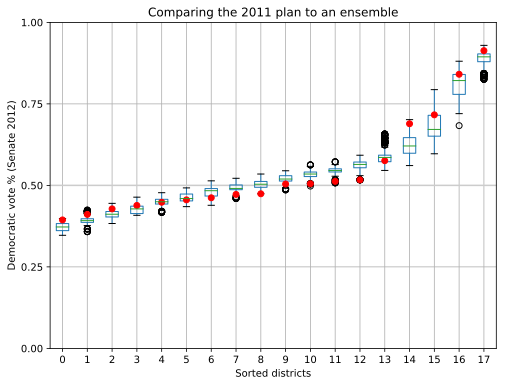

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(0, len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2012)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()